# Part 2: LZW

Including libraries

In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Input:- Filename, Block Size, codesize

In [13]:
imgfilename = 'Images/kodim23.png'
block_Size = 8
code_Size = 1              # in bits

In [14]:
def addPadding(img, blockSize):
    h, w = img.shape[0], img.shape[1]

    new_w, new_h = 0, 0

    if(w % blockSize != 0):
        r1 = w % blockSize
        new_w = blockSize - r1

    if(h % blockSize != 0):
        r2 = h % blockSize
        new_h = blockSize - r2

    newImg = np.zeros((new_h + h, new_w + w), dtype=np.int32)
    for i in range(h):
        for j in range(w):
            newImg[i, j] = int(img[i, j])
    
    return newImg

In [15]:
def append_list_to_file(filename, lst):
    with open(filename, 'a') as f:
        line = ""
        for x in lst:
            line += str(x) + " "
        
        line = line.strip()
        f.write(line + "\n")

In [16]:
def concat_set_and_list(mySet, myList):
    mySet.update(myList)
    return mySet

In [17]:
def lzw_encoder(block, blockSize, codeSize):
    dictn = dict()
    for i in range(256):
        dictn[str(i)] = i

    currnRecogSeq = ''
    encodedOp = []
    idx = 256
    for i in range(blockSize):
        for j in range(blockSize):
            pxBeingProc = str(block[i][j])
            if(currnRecogSeq == ''):
                currnRecogSeq = pxBeingProc
                continue

            if((currnRecogSeq + '-' + pxBeingProc) in dictn):
                currnRecogSeq = currnRecogSeq + '-' + pxBeingProc
            else:
                encodedOp.append(dictn[currnRecogSeq])
                if(idx <= (1 << codeSize)):
                    dictn[currnRecogSeq + '-' + pxBeingProc] = idx
                    idx += 1
                currnRecogSeq = pxBeingProc

    encodedOp.append(dictn[currnRecogSeq])
    
    return encodedOp, dictn

In [18]:
def lzw_decode(h, w, encodings, codeSize):
    decodeDict = []  
    for i in range(256):  
        decodeDict.append([i])

    idx = 256
    pattern = [encodings[0]]
    decodeBlock = []
    decodeBlock += pattern
    
    i = 1
    while i < len(encodings):
        encoding = encodings[i]
        if encoding in range(idx):
            curr = decodeDict[encoding]
        else:
            curr = pattern + [pattern[0]]
        
        decodeBlock += curr
        
        if(idx <= (1 << codeSize)):
            decodeDict.append(pattern + [curr[0]])
            idx += 1
        pattern = curr
        i += 1
    
    decodeBlock = np.array(decodeBlock)
    return decodeBlock.reshape((h, w))

In [19]:
def LZWEncoding(imgFileName, blockSize, codesSize):
    img = cv.imread(imgFileName)
    if(blockSize == -1):
        blockSize = min(img.shape[0], img.shape[1])
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = addPadding(img, blockSize)
    
    codefilename = 'img1_lzwcode.txt'
    with open(codefilename, 'w') as f:
        f.write(f"{img.shape[0]} {img.shape[1]} {blockSize}\n")

    maxCode = -1
    noOfCodes = 0
    avgBits = 0
    totalEntropy = 0
    
    i = 0
    while(i < img.shape[0]):
        j = 0
        while(j < img.shape[1]):
            block = img[i : i + blockSize, j : j + blockSize]
            encodedOp, dictn = lzw_encoder(block, blockSize, codesSize)
            
            counts = np.bincount(encodedOp)
            probabilities = counts / len(encodedOp) + (10 ** (-10))
            entropy = np.sum(probabilities * np.log2(probabilities))
            totalEntropy += entropy
            
            noOfCodes += len(encodedOp)
            
            avg_Bits_For_Block = (len(encodedOp) * codesSize) / (blockSize * blockSize)
            avgBits += avg_Bits_For_Block
            
            temp = max(encodedOp)
            maxCode = max(temp, maxCode)
            
            append_list_to_file(codefilename, encodedOp)
            j = j + blockSize

        i = i + blockSize
        if(i >= img.shape[0]):
            break

    noOfBlocks = img.shape[0] / blockSize
    avgBits /= (noOfBlocks * noOfBlocks)
    
    compRatio = (img.shape[0] * img.shape[1] * 8) / (noOfCodes * codesSize)
    
    print("Encoding written to file: img1_lzwcode.txt")
    print(f"Maximum value of code used is: {maxCode}")
    print(f"Number of codes used are: {noOfCodes}")
    print(f"Compression Ratio is: {compRatio}")
    print(f"Average length of encoded Pixels: {avgBits}")
    print(f"Entropy is: {-totalEntropy / (noOfBlocks * noOfBlocks)}")
    
    return codefilename

In [20]:
def LZWDecoding(codefilename, codesSize):
    i = 0
    j = 0

    with open(codefilename, "r") as f:
        h, w, blockSz = f.readline().split()
        h = int(h)
        w = int(w)
        blockSz = int(blockSz)
        
        outputImg = np.zeros((h, w))

        for line in f:
            encodingList = []

    #         if(line == ""):
    #             break

            encodingList = [int(x) for x in line.split()]
            block = lzw_decode(blockSz, blockSz, encodingList, codesSize)
            outputImg[i : i + blockSz, j : j + blockSz] = block

            if(j + blockSz >= w):
                i = i + blockSz
                j = 0
            else:
                j = j + blockSz
    
    return outputImg

# ENCODE HERE

In [21]:
codeFile = LZWEncoding(imgfilename, block_Size, code_Size)

Encoding written to file: img1_lzwcode.txt
Maximum value of code used is: 255
Number of codes used are: 393216
Compression Ratio is: 8.0
Average length of encoded Pixels: 1.5
Entropy is: 5.252976208404349


# DECODE HERE

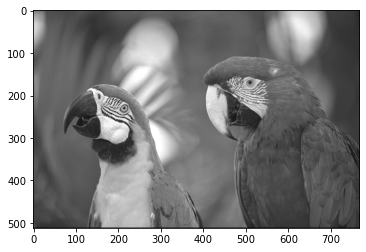

In [22]:
outputImg = LZWDecoding(codeFile, code_Size)
plt.imshow(outputImg, cmap='gray')